## Topic Modeling

In this notebook, I fetch my main dataset, which are 723 research articles from the _American Historical Review_ 1970 to 2005. Through sillhouette analysis and my own readings of the top terms loading onto each cluster, I find that 30 clusters seems to be the right number of clusters for this dataset. This makes semantic sense, given the fact that the _American Historical Review_ is a general-purpose journal in the historical discipline in the United States, with no set regional or methodological specialization. Indeed, I found that having the cluster number set too low (e.g. 5) buries a lot of important keywords that are representative of some portion of the corpus. 

Having identified an optimal cluster number through flat clustering methods, I build topic models of the corpus.


In [146]:
#Loading the relevant libraries
import sklearn
import sklearn.feature_extraction.text
import sklearn.pipeline
import sklearn.preprocessing
import sklearn.datasets
import sklearn.cluster
import sklearn.decomposition
import sklearn.metrics

import scipy #For hierarchical clustering and some visuals
#import scipy.cluster.hierarchy
import gensim#For topic modeling
import nltk #the Natural Language Toolkit
import requests #For downloading our datasets
import numpy as np #for arrays
import pandas #gives us DataFrames
import matplotlib.pyplot as plt #For graphics
import matplotlib.cm #Still for graphics
import seaborn as sns #Makes the graphics look nicer
import os
import sys
#This 'magic' command makes the plots work better
#in the notebook, don't use it outside of a notebook.
#Also you can ignore the warning, it
%matplotlib inline

import itertools
import json

import lucem_illud

You have to download all the nltk documents
[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to ../data...
[nltk_data]    |   Unzipping corpora/abc.zip.
[nltk_data]    | Downloading package alpino to ../data...
[nltk_data]    |   Unzipping corpora/alpino.zip.
[nltk_data]    | Downloading package biocreative_ppi to ../data...
[nltk_data]    |   Unzipping corpora/biocreative_ppi.zip.
[nltk_data]    | Downloading package brown to ../data...
[nltk_data]    |   Unzipping corpora/brown.zip.
[nltk_data]    | Downloading package brown_tei to ../data...
[nltk_data]    |   Unzipping corpora/brown_tei.zip.
[nltk_data]    | Downloading package cess_cat to ../data...
[nltk_data]    |   Unzipping corpora/cess_cat.zip.
[nltk_data]    | Downloading package cess_esp to ../data...
[nltk_data]    |   Unzipping corpora/cess_esp.zip.
[nltk_data]    | Downloading package chat80 to ../data...
[nltk_data]    |   Unzipping corpora/chat80.zip.
[nltk_data]    | 

[nltk_data]    |   Unzipping corpora/verbnet.zip.
[nltk_data]    | Downloading package webtext to ../data...
[nltk_data]    |   Unzipping corpora/webtext.zip.
[nltk_data]    | Downloading package wordnet to ../data...
[nltk_data]    |   Unzipping corpora/wordnet.zip.
[nltk_data]    | Downloading package wordnet_ic to ../data...
[nltk_data]    |   Unzipping corpora/wordnet_ic.zip.
[nltk_data]    | Downloading package words to ../data...
[nltk_data]    |   Unzipping corpora/words.zip.
[nltk_data]    | Downloading package ycoe to ../data...
[nltk_data]    |   Unzipping corpora/ycoe.zip.
[nltk_data]    | Downloading package rslp to ../data...
[nltk_data]    |   Unzipping stemmers/rslp.zip.
[nltk_data]    | Downloading package maxent_treebank_pos_tagger to
[nltk_data]    |     ../data...
[nltk_data]    |   Unzipping taggers/maxent_treebank_pos_tagger.zip.
[nltk_data]    | Downloading package universal_tagset to ../data...
[nltk_data]    |   Unzipping taggers/universal_tagset.zip.
[nltk_data

In [140]:
#Fetching data

targetArticles = 'American Historical Review'
ahrCategories = 5
targetDir = '../ahr_wordcounts_text' #Change this to your own directory of texts
articleText = []
articleFileName = []

In [84]:
for file in (file for file in os.scandir(targetDir) if file.is_file() and not file.name.startswith('.')):
    with open(file.path) as f:
        articleText.append(f.read())
    articleFileName.append(file.name)

In [150]:
import re

In [85]:
ahrTraining = pandas.DataFrame({'text' : articleText}, index = articleFileName)
ahrTFVectorizer = sklearn.feature_extraction.text.TfidfVectorizer(max_df=0.5, max_features=1000, min_df=3, stop_words='english', norm='l2')
ahrTFVects = ahrTFVectorizer.fit_transform(ahrTraining['text'])

## Flat clustering to identify optimal cluster number

In [143]:
#Reducing the dimensions to a Principal Component Analysis
ahrPCA = sklearn.decomposition.PCA(n_components = 2).fit(ahrTFVects.toarray())
pca = PCA(n_components = 2).fit(ahrTFVects.toarray())
ahrReducedPCA_data = ahrPCA.transform(ahrTFVects.toarray())

In [142]:
#K-Means clustering with 5 clusters
ahrKM = sklearn.cluster.KMeans(n_clusters = ahrCategories, init='k-means++')
ahrKM.fit(ahrTFVects.toarray())

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=5, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

Top terms per cluster:
Cluster 0:
 pp
 press
 editor
 editors
 cloth
 und
 der
 des
 die
 di


Cluster 1:
 soviet
 china
 chinese
 start
 workers
 editors
 party
 russian
 russia
 japanese


Cluster 2:
 des
 le
 medieval
 renaissance
 les
 du
 der
 king
 und
 christian


Cluster 3:
 film
 films
 images
 memory
 audience
 black
 narrative
 soviet
 editor
 islam


Cluster 4:
 slaves
 slavery
 slave
 african
 colonial
 black
 indians
 indian
 race
 racial




Text(0.5,1,'Predicted Clusters\n k = 5')

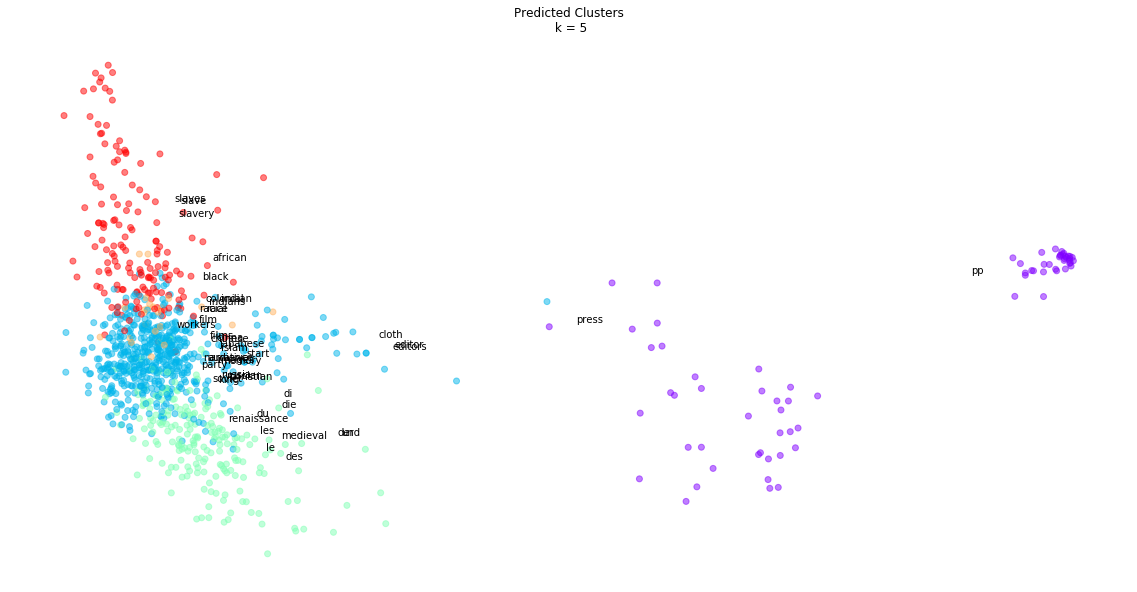

In [115]:
colors = list(plt.cm.rainbow(np.linspace(0,1, ahrCategories)))
colors_p = [colors[l] for l in ahrKM.labels_]

terms = ahrTFVectorizer.get_feature_names()
print("Top terms per cluster:")
order_centroids = ahrKM.cluster_centers_.argsort()[:, ::-1]
for i in range(ahrCategories):
    print("Cluster %d:" % i)
    for ind in order_centroids[i, :10]:
        print(' %s' % terms[ind])
    print('\n')
components = pca.components_
keyword_ids = list(set(order_centroids[:,:10].flatten())) #Get the ids of the most distinguishing words(features) from your kmeans model.
words = [terms[i] for i in keyword_ids]#Turn the ids into words.
x = components[:,keyword_ids][0,:] #Find the coordinates of those words in your biplot.
y = components[:,keyword_ids][1,:]


colors = list(plt.cm.rainbow(np.linspace(0,1, ahrCategories)))
colors_p = [colors[l] for l in ahrKM.labels_]
fig = plt.figure(1, figsize=(20,10))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
ax.scatter(ahrReducedPCA_data[:, 0], ahrReducedPCA_data[:, 1], color = colors_p, alpha = 0.5)
for i, word in enumerate(words):
    ax.annotate(word, (x[i],y[i]))
plt.xticks(())
plt.yticks(())
plt.title('Predicted Clusters\n k = {}'.format(ahrCategories))

In [118]:
def plotSilhouette(n_clusters, Y):
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize = (15,5))
    
    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(Y) + (n_clusters + 1) * 10])
    clusterer = sklearn.cluster.KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(Y)
    
    silhouette_avg = sklearn.metrics.silhouette_score(Y, cluster_labels)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = sklearn.metrics.silhouette_samples(Y, cluster_labels)

    y_lower = 10
    
    for i in range(n_clusters):
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = matplotlib.cm.prism(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        y_lower = y_upper + 10
    
    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = matplotlib.cm.prism(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(ahrReducedPCA_data[:, 0], ahrReducedPCA_data[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors)

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    projected_centers = pca.transform(centers)
    # Draw white circles at cluster centers
    ax2.scatter(projected_centers[:, 0], projected_centers[:, 1],
                marker='o', c="white", alpha=1, s=200)

    for i, c in enumerate(projected_centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1, s=50)

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("PC 1")
    ax2.set_ylabel("PC 2")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')
    plt.show()
    print("For n_clusters = {}, The average silhouette_score is : {:.3f}".format(n_clusters, silhouette_avg))

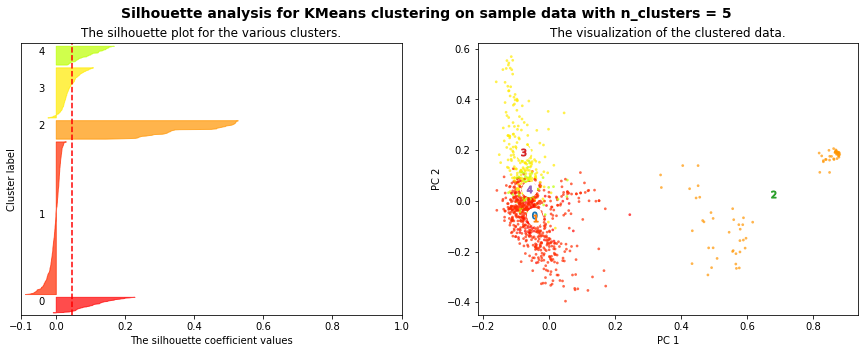

For n_clusters = 5, The average silhouette_score is : 0.046


In [119]:
Y = ahrTFVects.toarray()
plotSilhouette(5, Y)

In [130]:
#K-Means clustering with 20 clusters
ahrKM2 = sklearn.cluster.KMeans(n_clusters = 20, init='k-means++')
ahrKM2.fit(ahrTFVects.toarray())
colors = list(plt.cm.rainbow(np.linspace(0,1, 20)))
colors_p = [colors[l] for l in ahrKM2.labels_]

terms = ahrTFVectorizer.get_feature_names()
print("Top terms per cluster:")
order_centroids = ahrKM2.cluster_centers_.argsort()[:, ::-1]
for i in range(20):
    print("Cluster %d:" % i)
    for ind in order_centroids[i, :10]:
        print(' %s' % terms[ind])
    print('\n')
components = pca.components_
keyword_ids = list(set(order_centroids[:,:10].flatten())) #Get the ids of the most distinguishing words(features) from your kmeans model.
words = [terms[i] for i in keyword_ids]#Turn the ids into words.
x = components[:,keyword_ids][0,:] #Find the coordinates of those words in your biplot.
y = components[:,keyword_ids][1,:]

Top terms per cluster:
Cluster 0:
 colonial
 africa
 arab
 india
 comparative
 memory
 african
 muslim
 violence
 start


Cluster 1:
 le
 des
 les
 du
 histoire
 assembly
 sur
 revolutionary
 en
 au


Cluster 2:
 adams
 roosevelt
 court
 president
 papers
 americans
 box
 aha
 congress
 jefferson


Cluster 3:
 slaves
 slave
 slavery
 trade
 african
 africa
 black
 plantation
 davis
 capitalism


Cluster 4:
 der
 und
 germany
 die
 von
 berlin
 des
 marx
 germans
 das


Cluster 5:
 children
 sexual
 woman
 female
 male
 gender
 medical
 sex
 child
 welfare


Cluster 6:
 pp
 press
 cloth
 editor
 editors
 xii
 translated
 volume
 xi
 edition


Cluster 7:
 pp
 und
 der
 editors
 press
 editor
 des
 die
 cloth
 di


Cluster 8:
 black
 southern
 race
 negro
 cotton
 african
 blacks
 racial
 irish
 antebellum


Cluster 9:
 profession
 narrative
 professional
 scientific
 historiography
 discipline
 texts
 literary
 scholarship
 discourse


Cluster 10:
 spanish
 indians
 mexico
 indian
 spain

Text(0.5,1,'Predicted Clusters\n k = 20')

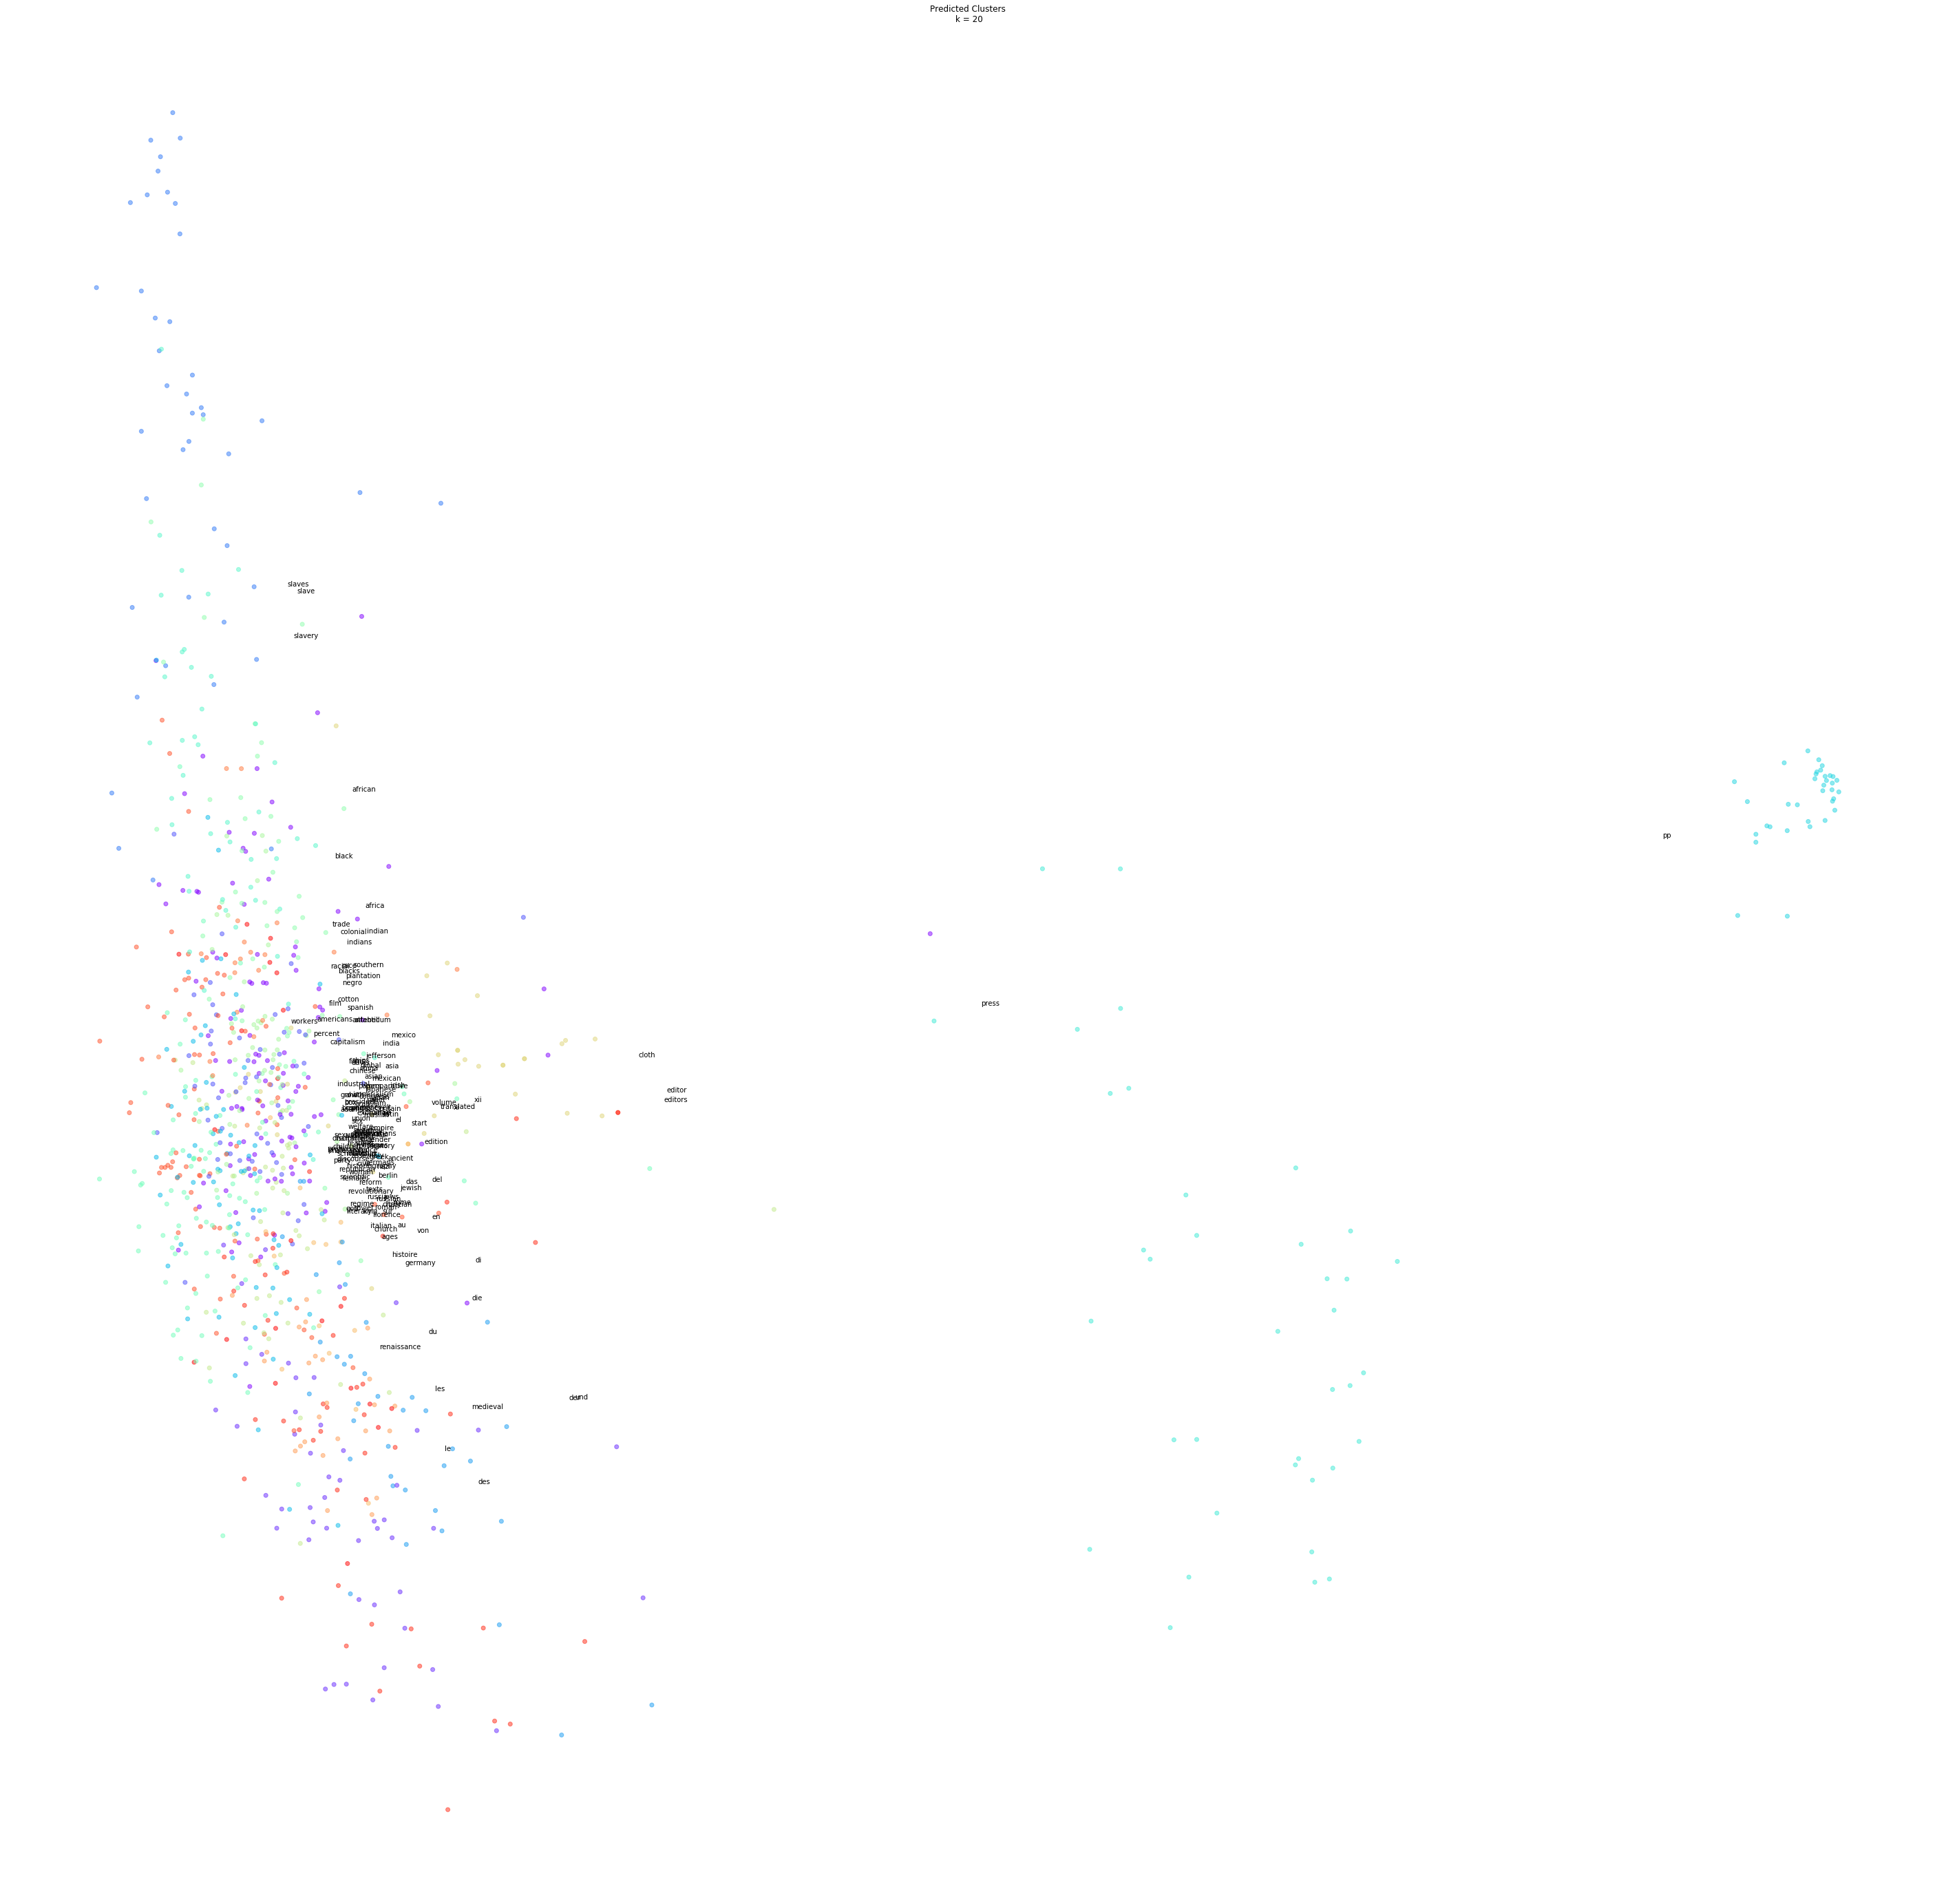

In [131]:
fig = plt.figure(1, figsize=(50,50))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
ax.scatter(ahrReducedPCA_data[:, 0], ahrReducedPCA_data[:, 1], color = colors_p, alpha = 0.5)
for i, word in enumerate(words):
    ax.annotate(word, (x[i],y[i]))
plt.xticks(())
plt.yticks(())
plt.title('Predicted Clusters\n k = {}'.format(20))

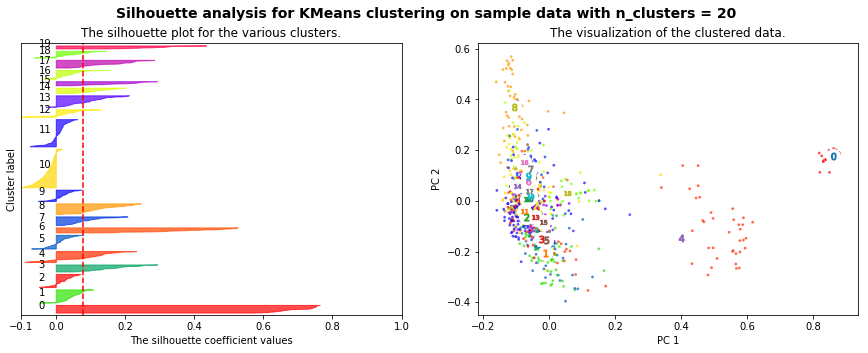

For n_clusters = 20, The average silhouette_score is : 0.079


In [125]:
Y = ahrTFVects.toarray()
plotSilhouette(20, Y)

In [132]:
#K-Means clustering with 30 clusters
ahrKM3 = sklearn.cluster.KMeans(n_clusters = 30, init='k-means++')
ahrKM3.fit(ahrTFVects.toarray())
colors = list(plt.cm.rainbow(np.linspace(0,1, 30)))
colors_p = [colors[l] for l in ahrKM3.labels_]

terms = ahrTFVectorizer.get_feature_names()
print("Top terms per cluster:")
order_centroids = ahrKM3.cluster_centers_.argsort()[:, ::-1]
for i in range(30):
    print("Cluster %d:" % i)
    for ind in order_centroids[i, :10]:
        print(' %s' % terms[ind])
    print('\n')
components = pca.components_
keyword_ids = list(set(order_centroids[:,:10].flatten())) #Get the ids of the most distinguishing words(features) from your kmeans model.
words = [terms[i] for i in keyword_ids]#Turn the ids into words.
x = components[:,keyword_ids][0,:] #Find the coordinates of those words in your biplot.
y = components[:,keyword_ids][1,:]

Top terms per cluster:
Cluster 0:
 start
 italian
 comparative
 italy
 scott
 press
 comparison
 revolutionary
 method
 museum


Cluster 1:
 le
 medieval
 des
 les
 du
 king
 ages
 histoire
 royal
 au


Cluster 2:
 pp
 und
 der
 editors
 press
 editor
 des
 die
 cloth
 di


Cluster 3:
 workers
 industrial
 business
 technology
 percent
 trade
 growth
 wealth
 urban
 production


Cluster 4:
 colonial
 africa
 african
 empire
 africans
 imperial
 colonies
 workers
 britain
 imperialism


Cluster 5:
 children
 female
 woman
 sexual
 male
 gender
 medical
 welfare
 sex
 child


Cluster 6:
 soviet
 stalin
 moscow
 union
 russian
 russia
 party
 communist
 workers
 cold


Cluster 7:
 renaissance
 florence
 di
 italian
 civic
 rome
 italy
 republican
 del
 medieval


Cluster 8:
 pp
 press
 cloth
 editor
 editors
 xii
 translated
 volume
 xi
 edition


Cluster 9:
 russian
 russia
 moscow
 soviet
 balance
 germany
 peasant
 imperial
 regime
 bourgeois


Cluster 10:
 memory
 professor
 religion


Text(0.5,1,'Predicted Clusters\n k = 30')

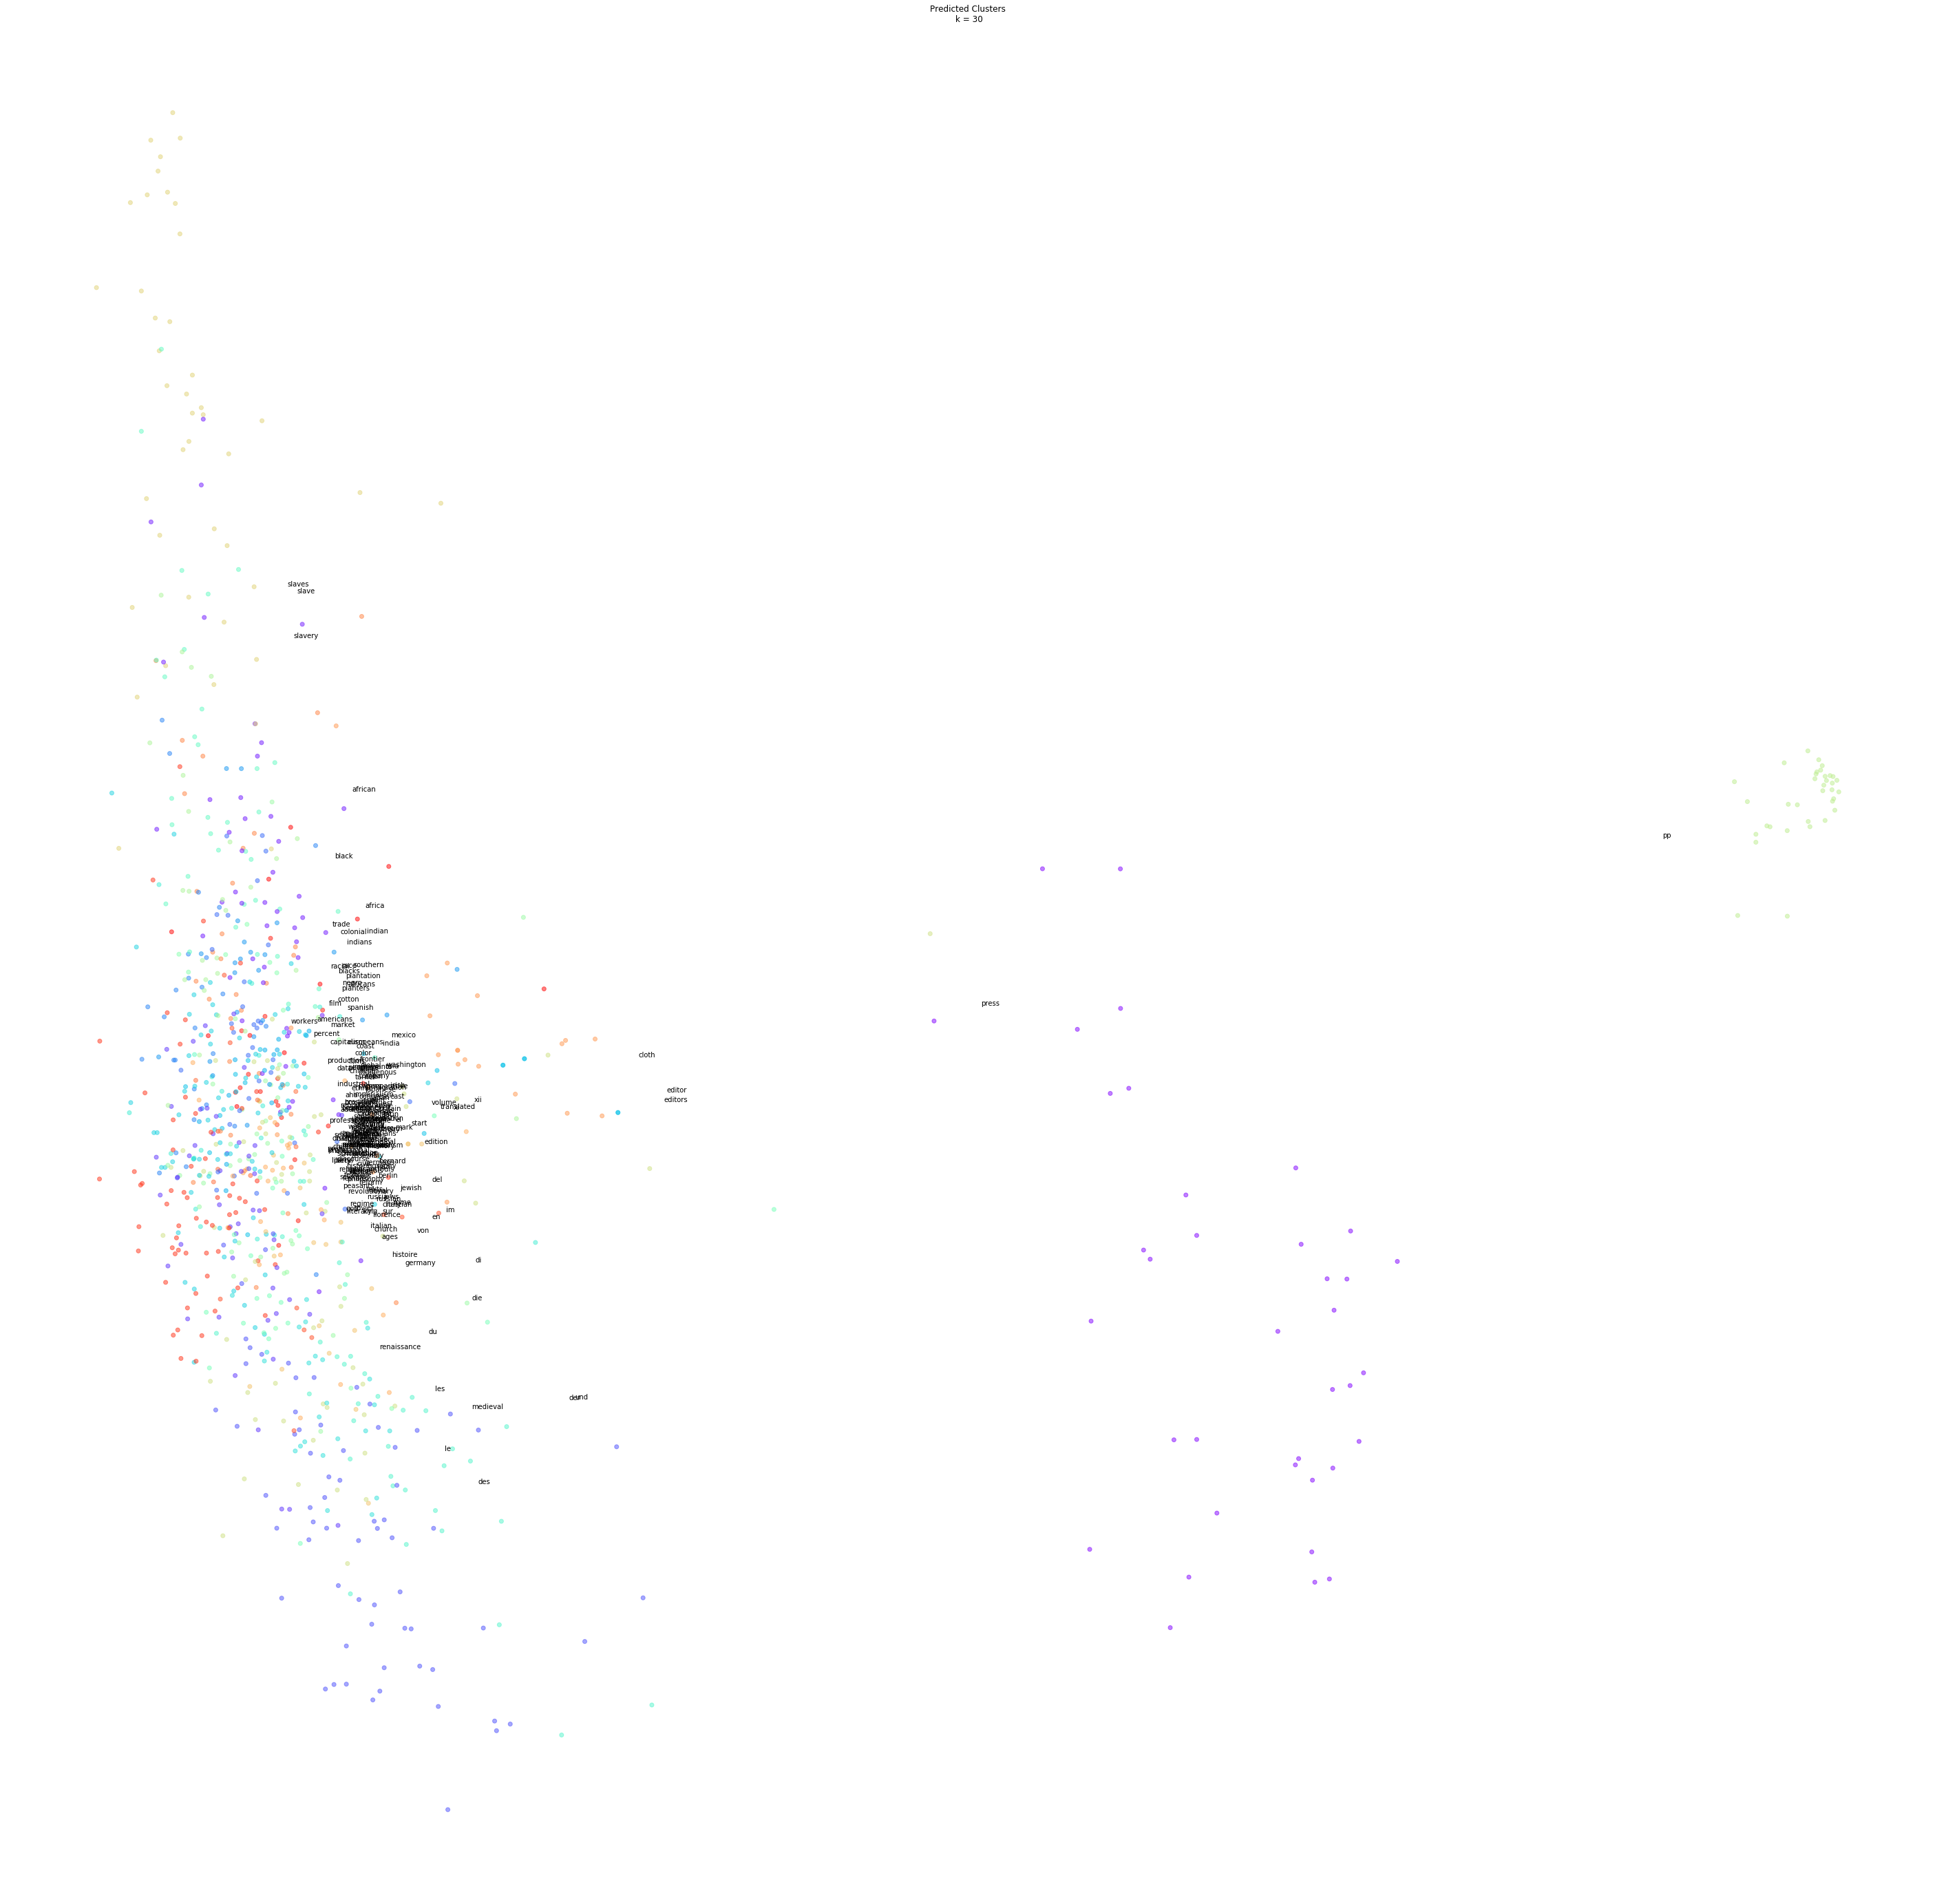

In [128]:
fig = plt.figure(1, figsize=(50,50))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
ax.scatter(ahrReducedPCA_data[:, 0], ahrReducedPCA_data[:, 1], color = colors_p, alpha = 0.5)
for i, word in enumerate(words):
    ax.annotate(word, (x[i],y[i]))
plt.xticks(())
plt.yticks(())
plt.title('Predicted Clusters\n k = {}'.format(30))

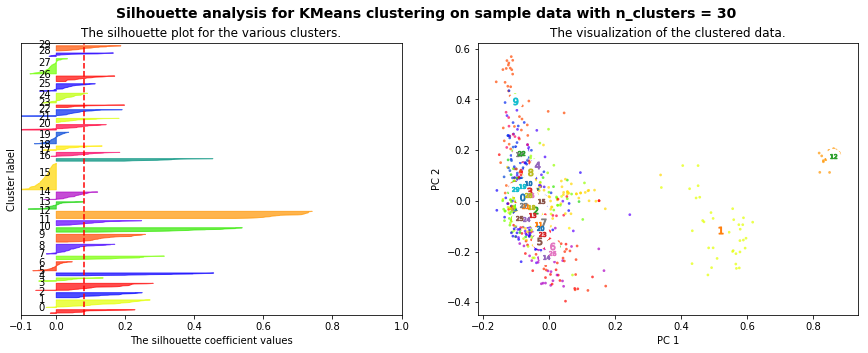

For n_clusters = 30, The average silhouette_score is : 0.082


In [107]:
Y = ahrTFVects.toarray()
plotSilhouette(30, Y)

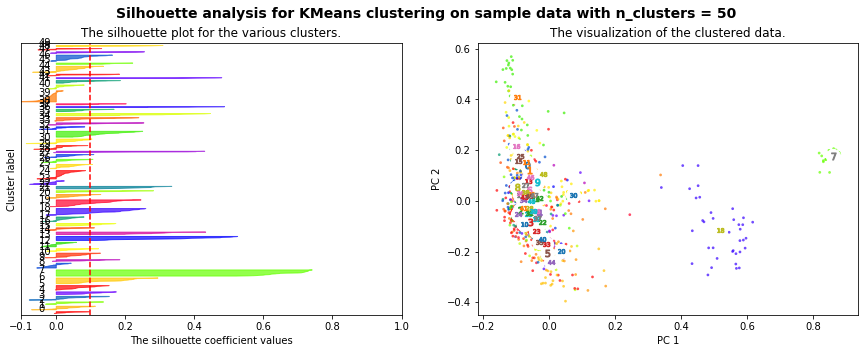

For n_clusters = 50, The average silhouette_score is : 0.099


In [133]:
Y = ahrTFVects.toarray()
plotSilhouette(50, Y)

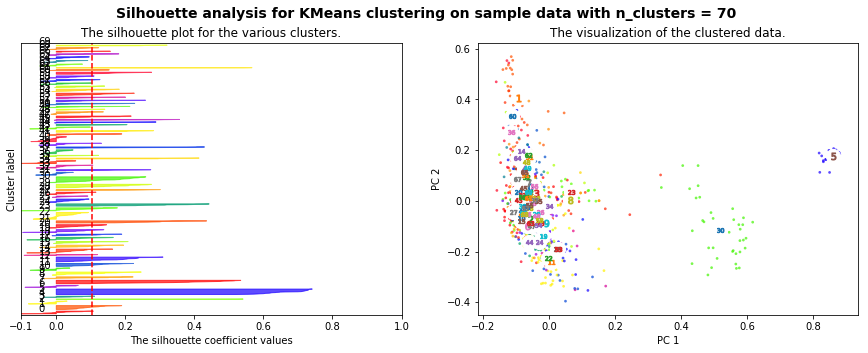

For n_clusters = 70, The average silhouette_score is : 0.104


In [134]:
Y = ahrTFVects.toarray()
plotSilhouette(70, Y)

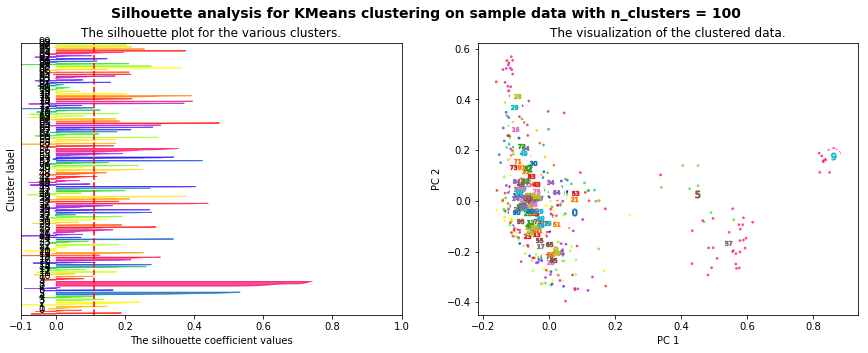

For n_clusters = 100, The average silhouette_score is : 0.110


In [135]:
Y = ahrTFVects.toarray()
plotSilhouette(100, Y)

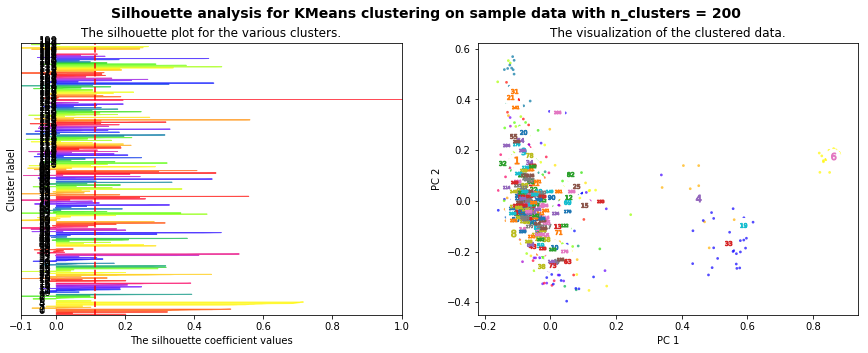

For n_clusters = 200, The average silhouette_score is : 0.115


In [136]:
Y = ahrTFVects.toarray()
plotSilhouette(200, Y)

## Topic modeling 

In [164]:
#Processing the corpus
ahrTraining['tokenized_text'] = ahrTraining['text'].apply(lambda x: nltk.word_tokenize(x))

In [190]:
ahrTraining['normalized_tokens'] = ahrTraining['tokenized_text'].apply(lambda x: lucem_illud.normalizeTokens(x, 
                                                                                                                            stopwordLst = 'https://github.com/agoldst/dfr-analysis/blob/master/demo/stoplist.txt', 
                                                                                                                            stemmer = lucem_illud.stemmer_basic))

In [168]:
def dropMissing(wordLst, vocab):
    return [w for w in wordLst if w in vocab]

ahrTraining['reduced_tokens'] = ahrTraining['normalized_tokens'].apply(lambda x: dropMissing(x, ahrTFVectorizer.vocabulary_.keys()))

dictionary = gensim.corpora.Dictionary(ahrTraining['reduced_tokens'])

In [169]:
corpus = [dictionary.doc2bow(text) for text in ahrTraining['reduced_tokens']]
gensim.corpora.MmCorpus.serialize('ahr.mm', corpus)
ahrmm = gensim.corpora.MmCorpus('ahr.mm')

In [178]:
ahrlda = gensim.models.ldamodel.LdaModel(corpus=ahrmm, id2word=dictionary, num_topics=30, alpha='auto', eta='auto')

In [179]:
ahr1Bow = dictionary.doc2bow(ahrTraining['reduced_tokens'][0])
ahr1lda = ahrlda[ahr1Bow]
ahrTraining['name'] = ahrTraining.index
ahrDF = pandas.DataFrame({
        'name' : ahrTraining['name'],
        'topics' : [ahrlda[dictionary.doc2bow(l)] for l in ahrTraining['reduced_tokens']]
    })

In [188]:
topicsProbDict = {i : [0] * len(ahrDF) for i in range(ahrlda.num_topics)}
for index, topicTuples in enumerate(ahrDF['topics']):
    for topicNum, prob in topicTuples:
        topicsProbDict[topicNum][index] = prob
for topicNum in range(ahrlda.num_topics):
    ahrDF['topic_{}'.format(topicNum)] = topicsProbDict[topicNum]

    
ahrDFV = ahrDF[:10][['topic_%d' %x for x in range(10)]]
ahrDFVisN = ahrDF[:10][['name']]
ahrDFVis = ahrDFV.as_matrix(columns=None)
ahrDFVisNames = ahrDFVisN.as_matrix(columns=None)

In [189]:
topicsDict = {}
for topicNum in range(ahrlda.num_topics):
    topicWords = [w for w, p in ahrlda.show_topic(topicNum)]
    topicsDict['Topic_{}'.format(topicNum)] = topicWords

wordRanksDF = pandas.DataFrame(topicsDict)
wordRanks

,Topic_0,Topic_1,Topic_10,Topic_11,Topic_12,Topic_13,Topic_14,Topic_15,Topic_16,Topic_17,...,Topic_27,Topic_28,Topic_29,Topic_3,Topic_4,Topic_5,Topic_6,Topic_7,Topic_8,Topic_9
0,pp,court,black,china,region,worker,peasant,soviet,christian,slave,...,black,christian,letter,soviet,indian,african,trade,mean,pp,miller
1,press,sexual,soviet,japan,origin,reform,region,worker,reform,trade,...,slave,stalin,trade,russian,film,slave,slave,product,product,soviet
2,slave,person,worker,worker,press,jefferson,press,trade,mean,le,...,negro,letter,write,origin,christian,africa,des,write,court,muslim
3,trade,jewish,pp,report,start,mean,republican,space,black,african,...,race,vol,slave,russia,der,trade,follow,person,press,islam
4,editor,report,product,indian,write,union,tax,union,origin,worker,...,children,write,pp,write,peasant,east,indian,text,mexico,wealth
5,africa,slave,report,live,event,professor,court,arab,slave,des,...,racial,text,press,mean,worker,product,und,live,editor,ottoman
6,indian,live,box,region,und,ethnic,origin,report,vote,percent,...,fear,le,editor,report,origin,le,mean,start,market,percent
7,african,remain,union,italian,mean,le,le,reform,person,africa,...,african,roman,mean,follow,und,film,origin,peasant,cloth,mean
8,court,follow,peasant,person,live,racial,follow,record,report,report,...,live,des,mexico,person,black,report,der,distinct,der,christian
9,cloth,peasant,live,write,gender,member,worker,wage,live,origin,...,southern,pp,african,live,reform,pp,letter,household,des,japan
